# Usando voronoi para entender a cobertura de pontos em uma região ou Qual a abrangência de um ponto de ônibus na cidade de são paulo?
Essa pergunta me ocorreu estes dias, e somado a isso a distância que uma pessoa precisa percorrer para chegar a um ponto de onibus, lembrando que as regiões tem declividade e que isso pode afetar a sensação de distância entre um ponto de ônibus e o local de origem.
Além deste fato, vou verificar a densidade populacional das áres (aproximada) que pode ser um indicativo de quanto o ponto de ônibus abrange a população

### Bom vamos ver a análise de dados
Em primeiro lugar vamos importar os módulos. Como os arquivos da prefeitura são shapes, precisaremos de uma biblioteca para isso. E naturalmente outra para visualizar os dados. Eu optarei pelo matplotlib. Em seguida como precisaremos de um algoritimo próprio parar este tipo de análise. Usarei voronoi.

### Dados Utilizados
Os dados foram obtidos da plataforma da prefeitura da cidade de são paulo:
http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx
os dados baixados são :
* Localiação dos pontos de ônibus
* Densidade demográfica
* Topografia


In [1]:
import geopandas as gpd
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
import re
import numpy as np
from shapely.geometry import LineString,asMultiPoint
from shapely.ops import polygonize,unary_union

%matplotlib inline


# Primeiros passos
Em análise de dados é sempre bom primeiramente darmos uma olhada nos dados, o site em que eu fiz os downloads já me deram algumas dicas do que temos nos arquiovs mas é sempre bom conferir!

Index(['geometry', 'pt_descric', 'pt_enderec', 'pt_nome'], dtype='object')


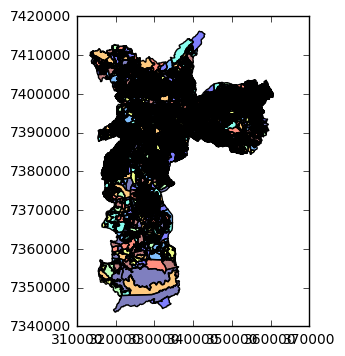

In [2]:
pontos = gpd.read_file('../GIS/DadosSampa/SIRGAS_SHP_pontoonibus/SIRGAS_SHP_pontoonibus_point.shp')
print(pontos.columns)
densidade = gpd.read_file('../GIS/DadosSampa/SIRGAS_SHP_densidade_demografica_2010.shp')
densidade.head()

densidade.plot()

bom temos os dados da cidade, aparentemente esta tudo em ordem, vou precisar lembrar de remover as linhas se for plotar mais alguma coisa

Me ocorreu que a análise de voronoi não pode ser diretamente aplicada. pois no caso de ponto de ônibus na mesma rua será interessante considera-los como um único, pois dessa forma considera-se como 1 o ponto de ônibus de ida e volta, que em quase todos os casos não é o mesmo. Portanto esta é mais uma implicação da análise. Vou começar a resolver o problema por aí.

In [3]:
# olhando o cabeçalho dos pontos de ônibus
pontos.head()


,geometry,pt_descric,pt_enderec,pt_nome
0,POINT (319094.8392643448 7385513.190575708),Ref.: R Campina Grande/ Av Vitor Gabriel,R Campina Grande/ Av Vitor Gabriel,Terminal Campo Limpo
1,POINT (349413.6174407193 7387737.499860981),Ref.: Av Sapopemba/ Pc Felisberto Fernandes Da...,Av Sapopemba/ Pc Felisberto Fernandes Da Silva,Terminal S. Mateus - Plat. C
2,POINT (332582.4540150195 7378078.002008434),Ref.: R Dos Curimatas/ R Delfim Do Prata,R Dos Curimatas/ R Delfim Do Prata,"R. Cardoso De Melo Neto, 497"
3,POINT (350253.9040314286 7389086.161001192),Ref.: Rua Forte Do Araxá / Forte Do Rio Negro,Rua Forte Do Araxá / Forte Do Rio Negro,"Av. Forte Do Leme, 360"
4,POINT (349019.6847513096 7393468.142417993),Ref.: R Carlos Jose De Castilho/ R Seis,R Carlos Jose De Castilho/ R Seis,"R. Morubixaba, 69"


Bom os nomes do ponto apresentam a numeração da rua separado por vírgula. Assumindo que os pontos opostos para ida e volta estão na mesma rua, porém um com numeração ímpar e outro com numeração par vou criar um indicador que vai apontar o número do ponto de ônibus e outro para se par ou se impar

In [4]:
# pegar os numeros dos pontos

def CheckOddNumber(x):
    texts = x.split(',')
    if len(texts)==1:
        odd=None
    else:
        try:
            odd=int(texts[-1])% 2
        except:
            print(texts)
            odd=None
            pass
        
    return odd

pontos['StreetSide'] = pontos['pt_nome'].apply(CheckOddNumber)

pontos.head()

            
            

['R. Mmdc', ' 380 Ref.: Rua Camargo (lateral Do Terminal Butantã)']
['Pça. Manoel Liodoro Da Silva', ' 900 Ref.: R Anajazeira / R Anton']
['R. Mmdc', ' 364 Ref.: Lateral Terminal Butantã']


,geometry,pt_descric,pt_enderec,pt_nome,StreetSide
0,POINT (319094.8392643448 7385513.190575708),Ref.: R Campina Grande/ Av Vitor Gabriel,R Campina Grande/ Av Vitor Gabriel,Terminal Campo Limpo,NaN
1,POINT (349413.6174407193 7387737.499860981),Ref.: Av Sapopemba/ Pc Felisberto Fernandes Da...,Av Sapopemba/ Pc Felisberto Fernandes Da Silva,Terminal S. Mateus - Plat. C,NaN
2,POINT (332582.4540150195 7378078.002008434),Ref.: R Dos Curimatas/ R Delfim Do Prata,R Dos Curimatas/ R Delfim Do Prata,"R. Cardoso De Melo Neto, 497",1.0
3,POINT (350253.9040314286 7389086.161001192),Ref.: Rua Forte Do Araxá / Forte Do Rio Negro,Rua Forte Do Araxá / Forte Do Rio Negro,"Av. Forte Do Leme, 360",0.0
4,POINT (349019.6847513096 7393468.142417993),Ref.: R Carlos Jose De Castilho/ R Seis,R Carlos Jose De Castilho/ R Seis,"R. Morubixaba, 69",1.0


Tive um erro aqui no dados, há 3 nomes que não se encaixaram no algoritimo. Bom a solução será a alteração do algoritimo para considerar estas situações, em seguida vou aproveitar extrair o nome da rua para a correlação

In [5]:
# pegar os numeros dos pontos
def CheckOddNumber(x):
    texts = x.split(',')
    if len(texts)==1:
        odd=None
    else:
        texts = re.findall(r'\d+',texts[-1])[0]
        odd=int(texts)% 2
        
    return odd

pontos['StreetSide'] = pontos['pt_nome'].apply(CheckOddNumber)

def StopName(x):
    StreetName = x.split(',')
    return StreetName[0]
    
pontos['StreetName'] = pontos['pt_nome'].apply(StopName)
pontos.head()


,geometry,pt_descric,pt_enderec,pt_nome,StreetSide,StreetName
0,POINT (319094.8392643448 7385513.190575708),Ref.: R Campina Grande/ Av Vitor Gabriel,R Campina Grande/ Av Vitor Gabriel,Terminal Campo Limpo,NaN,Terminal Campo Limpo
1,POINT (349413.6174407193 7387737.499860981),Ref.: Av Sapopemba/ Pc Felisberto Fernandes Da...,Av Sapopemba/ Pc Felisberto Fernandes Da Silva,Terminal S. Mateus - Plat. C,NaN,Terminal S. Mateus - Plat. C
2,POINT (332582.4540150195 7378078.002008434),Ref.: R Dos Curimatas/ R Delfim Do Prata,R Dos Curimatas/ R Delfim Do Prata,"R. Cardoso De Melo Neto, 497",1.0,R. Cardoso De Melo Neto
3,POINT (350253.9040314286 7389086.161001192),Ref.: Rua Forte Do Araxá / Forte Do Rio Negro,Rua Forte Do Araxá / Forte Do Rio Negro,"Av. Forte Do Leme, 360",0.0,Av. Forte Do Leme
4,POINT (349019.6847513096 7393468.142417993),Ref.: R Carlos Jose De Castilho/ R Seis,R Carlos Jose De Castilho/ R Seis,"R. Morubixaba, 69",1.0,R. Morubixaba



Verificar quantas ruas temos com pontos de onibus e qual a distribução de pontos por rua (desconsiderando as ruas com até três ponto por conta de provavelmente serem a maior ocorrencia)


O numero de ruas, avenidas e terminais com pontos de ônibus é de :5895
Destes, 25.48% apresentam mais de 3 pontos de parada


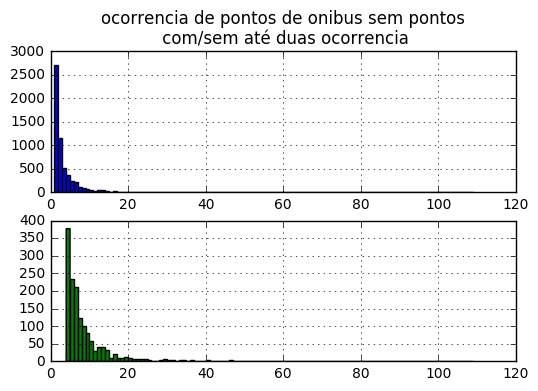

In [6]:
nruas = len(pontos.StreetName.unique())


pontosDeOnibusPorRua = pontos.StreetName.value_counts()

fig, axes = plt.subplots(nrows=2, ncols=1)
ax1,ax2=axes

pontosDeOnibusPorRua.hist(ax=ax1,bins=range(1,110))
pontosDeOnibusPorRua.loc[pontosDeOnibusPorRua>3].hist(bins=range(4,110),ax=ax2,color='green')

ax1.set_title('ocorrencia de pontos de onibus sem pontos\n com/sem até duas ocorrencia')

NRuasMaisPontos = pontosDeOnibusPorRua.loc[pontosDeOnibusPorRua>3].shape[0]

print('O numero de ruas, avenidas e terminais com pontos de ônibus é de :{}'.format(nruas))
print('Destes, {:0.2f}% apresentam mais de 3 pontos de parada'.format(NRuasMaisPontos/nruas*100))

Agora que tenho uma noção do tamanho do problema vamos começar a misturar as coisas, primeiro descobrir quais ruas tem ao menos um ponto de cada lado

In [7]:
# Sum indicadores
SomaDosIndicadores=pontos.groupby('StreetName')['StreetSide'].sum().dropna()
SomaDosIndicadores = SomaDosIndicadores.loc[SomaDosIndicadores>0]
# gets same index
SomaDosIndicadores = SomaDosIndicadores.loc[pontosDeOnibusPorRua.index].dropna()
SelRuas = pontosDeOnibusPorRua.loc[SomaDosIndicadores.index].sort_values()-SomaDosIndicadores.sort_values()
SelRuas=SelRuas[SelRuas>0]



Agora que as ruas já foram selecionadas, vamos começar com o processamento que vai demorar um tanto por conta do numero de interações
Estou na dúvida da técnica. Não sei se uso clusterização ou queries em kd-trees. 

Dando uma zapeada na internet aparentemente as trees são mais rápidas. Vou optar por elas então. Para mim o importante é saber apenas quem esta mais perto de quem sem me preocupar muito com a distância e também sem me preocupar muito com outras coisas.

Um comentário importante é que eu preciso saber se existem os mesmos números de ímpares e pares na rua. Caso não existam eles vão falsear a minha analise.
Um erro também que você já deve ter reparado é que pode ser que o ponto sequencial ao da rua analisada seja na rua seguinte do trajeto do ônibus e ela não vai entrar. Bom não tem muito o que fazer a respeito disso. Teria que fazer outra análise. Mas isso não falseará em todo os meus resultados.

In [8]:
# importar a biblioteca para construir uma árvore.
from scipy.spatial import KDTree
# vamos agora criar uma função para o teste, primeiro. Vou começar pegando uma rua e criando a árvore dela
print('numero de ruas igual a {}'.format(len(SelRuas.index)))
# escolher uma rua qualquer
print(SelRuas[100])
# boa escolha !!!

# agora vamos ver
# primeiro vamos contar numero de pares e ímpares
pontos.query('StreetName=="{}"'.format(SelRuas.index[100]))

numero de ruas igual a 2153
11.0


,geometry,pt_descric,pt_enderec,pt_nome,StreetSide,StreetName
509,POINT (322791.5684378004 7384516.683245565),Ref.: Av Giovanni Gronchi/ R Joaquim Nunes Tei...,Av Giovanni Gronchi/ R Joaquim Nunes Teixeira,Av. Carlos Caldeira Filho,NaN,Av. Carlos Caldeira Filho
1182,POINT (320862.7998921822 7383837.72356685),Ref.: R Nossa Senhora Do Bom Conselho/ R Douto...,R Nossa Senhora Do Bom Conselho/ R Doutor Osva...,"Av. Carlos Caldeira Filho, 128",0.0,Av. Carlos Caldeira Filho
1342,POINT (322322.0181831327 7384698.038678444),Ref.: R Joao Calixto/ R Joaquim Nunes Teixeira,R Joao Calixto/ R Joaquim Nunes Teixeira,"Av. Carlos Caldeira Filho, 80",0.0,Av. Carlos Caldeira Filho
2439,POINT (321825.1748060212 7384414.959889678),Ref.: Av Das Belezas/ R Baldomero Carqueja,Av Das Belezas/ R Baldomero Carqueja,"Av. Carlos Caldeira Filho, 233",1.0,Av. Carlos Caldeira Filho
4379,POINT (320816.6905522985 7383787.092383807),Ref.: R Nossa Senhora Do Bom Conselho/ Est Do ...,R Nossa Senhora Do Bom Conselho/ Est Do Campo ...,Av. Carlos Caldeira Filho,NaN,Av. Carlos Caldeira Filho
5484,POINT (319622.7927479505 7382335.995355017),Ref.: R Roberto Campos Rodrigues/ R Miguel Auza,R Roberto Campos Rodrigues/ R Miguel Auza,Av. Carlos Caldeira Filho,NaN,Av. Carlos Caldeira Filho
9489,POINT (320585.2582132386 7383374.315880066),Ref.: R Rogerio De Paula Brito/ R Antonio Barbato,R Rogerio De Paula Brito/ R Antonio Barbato,"Av. Carlos Caldeira Filho, 3010",0.0,Av. Carlos Caldeira Filho
13247,POINT (322733.6209178331 7384683.558114827),Ref.: Concessionária Honda Sp Japan,Concessionária Honda Sp Japan,"Av. Carlos Caldeira Filho, 389",1.0,Av. Carlos Caldeira Filho
13469,POINT (321787.3731327041 7384201.948121737),Ref.: Av Das Belezas/ R Baldomero Carqueja,Av Das Belezas/ R Baldomero Carqueja,"Av. Carlos Caldeira Filho, 1651",1.0,Av. Carlos Caldeira Filho
14396,POINT (322400.3877872862 7384748.060816426),Ref.: R Joao Calixto/ R Joaquim Nunes Teixeira,R Joao Calixto/ R Joaquim Nunes Teixeira,"Av. Carlos Caldeira Filho, 5722",0.0,Av. Carlos Caldeira Filho


## Aquele momento em que encontramos problemas nos dados. =(

Vimos um problema grave aqui. O índice 509 apresenta o nome Carlos Caldeira Filho no pt_nome mas não é o endereço do ponto de ônibus. Isso significa um baita contratempo. 

Esse problema de nomenclatura foi observado também no dado original. Dando uma olhada no google maps Nomes repetidos sem número com endereços diferentes ou errôneos. Bom neste caso faremos o seguinte, vamos desonsiderar os pontos de ônibus que não apresentam números. Vamos nos restringir a agrupar apenas os pontos que apresentam números. Isso colocará um pouco mais de erro na nossa análise. Subestimando mais um pouco as áreas de abrangência dos pontos de ônibus. Mesmo assim, vamos assumir este erro.

Para isso vamos começar fazendo o seguinte. Remover as colunas que não preciso e em seguida trabalhar com os dados que não são nulos mesmo

In [9]:
# remover colunas
try:
    pontos.drop(['pt_descric','pt_enderec'],axis=1,inplace=True)
except:
    pass
# remover nans e contar numeros de pares e ímpares
ParesImpares = pontos.query('StreetName=="{}"'.format(SelRuas.index[100])).dropna()['StreetSide'].value_counts()
print(ParesImpares)
# verificar se o 1 tem mais e colocar em uma árvore caso contrário colocar o 0
if ParesImpares.loc[0]<ParesImpares.loc[1]:
    StreetSide=1
else:
    StreetSide=0

# obter as coordenadas
bnds=pontos.query('StreetSide=={} and StreetName=="{}"'.format(StreetSide,SelRuas.index[100])).geometry.bounds
# converter para lista
consultados = zip(bnds['minx'].values,bnds['miny'].values)

# idem processo anterior
StreetSide =abs(StreetSide-1)
bnds=pontos.query('StreetSide=={} and StreetName=="{}"'.format(StreetSide,SelRuas.index[100])).geometry.bounds
consulta = zip(bnds['minx'].values,bnds['miny'].values)
del bnds
# criar árvore
tree = KDTree(list(consultados))
# fazer as consultas 
dist,ind = tree.query(list(consulta))

0.0    7
1.0    5
Name: StreetSide, dtype: int64


## Agora momento de colocar esta consulta em produção 

 Unir os pontos em um único considerando o ponto médio e valores abaixo de 400m (que eu já acho um valor meio abusivo mas considerando os resultados...)

In [10]:

def MergeBusStops(Ruas,pontos,limit=400):
    # remover nans e contar numeros de pares e ímpares
    ParesImpares = pontos.query('StreetName=="{}"'.format(Ruas)).dropna()['StreetSide'].value_counts()
    
    if ParesImpares.shape[0]==2:
        # verificar se o 1 tem mais e colocar em uma árvore caso contrário colocar o 0
        if ParesImpares.loc[0]<ParesImpares.loc[1]:
            StreetSide=1
        else:
            StreetSide=0

        # obter as coordenadas
        bnds=pontos.query('StreetSide=={} and StreetName=="{}"'.format(StreetSide,Ruas)).geometry.bounds

        IndConsultados=pontos.query('StreetSide=={} and StreetName=="{}"'.format(StreetSide,Ruas)).index

        # converter para lista
        consultados = zip(bnds['minx'].values,bnds['miny'].values)

        # idem processo anterior
        StreetSide =abs(StreetSide-1)
        bnds=pontos.query('StreetSide=={} and StreetName=="{}"'.format(StreetSide,Ruas)).geometry.bounds
        consulta = zip(bnds['minx'].values,bnds['miny'].values)

        IndConsulta=pontos.query('StreetSide=={} and StreetName=="{}"'.format(StreetSide,Ruas)).index

        # criar árvore
        tree = KDTree(list(consultados))
        # fazer as consultas 
        dist,ind = tree.query(list(consulta))
        IndConsulta=IndConsulta[dist<=limit]
        IndConsultados=IndConsultados[ind[dist<=limit]]
        for i,j in zip(IndConsulta,IndConsultados):
            line = LineString(tuple(pontos.loc[[i,j]].geometry.values))
            pontos.loc[i,'geometry'] = line.centroid.xy
        # remover os pontos
        pontos.drop(IndConsultados,axis=0,inplace=True)
    
        pontos.drop(IndConsulta,axis=0,inplace=True)
    
    return pontos


for Ruas in SelRuas.index:

    pontos = MergeBusStops(Ruas,pontos,limit=400)
    

## Aplicando voronoi

1. Para aplicar o algoritimo de voronoi precisamos converter tudo para um array de x e y. 
2. Em seguida aplicar o algoritimo e muito provavelmente escrever linhas. 
4. converter as linhas para polígonos e pronto
5. Recortar as linhas nos limites da cidade, 

In [13]:
# pegando as coordenadas dos pontos
bnds = pontos.geometry.bounds
# converterndo para matrix
points = bnds.loc[:,['minx','miny']].as_matrix()

# voronoi
vor = Voronoi(points)

# create lines
lines = [LineString(vor.vertices[line]) for line in vor.ridge_vertices ]
# create polygons
poly = list(polygonize(lines))


LimitsDaCidade = unary_union(densidade.geometry.values)

intersects = lambda x:LimitsDaCidade.intersection(x)



## Plotando

Agora vamos dar um confere e se estiver tudo certo, criar um geopandas e calcular a área de todos os polígonos gerados, e assim ter uma noção da área de abrangência.

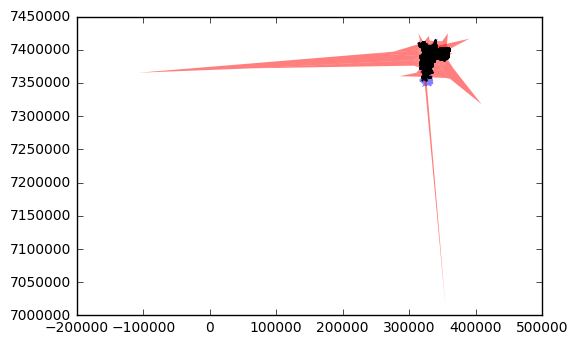

In [13]:

area=list(map(lambda x:x.area,poly))
gdf = gpd.GeoDataFrame(area,geometry=poly,crs=densidade.crs)
sp = gpd.GeoDataFrame(['cidade'],geometry=[LimitsDaCidade],crs=densidade.crs)
ax = sp.plot(facecolor='blue',edgecolor='none')
gdf.plot(ax=ax,facecolor='red',edgecolor='none')
originais = gpd.read_file('../GIS/DadosSampa/SIRGAS_SHP_pontoonibus/SIRGAS_SHP_pontoonibus_point.shp')
originais.plot(ax=ax,color='black',markersize=1)



Bom da pra ver que algumas áreas de cidade, não foram consideradas, isso por conta do algoritimo de voronoi que desconsidera as pontas. Mesmo assim observamos na perfieria das zonas norte, noroeste e sul, áreas com quase nenhum ponto de ônibus. vamos ver agora a abrangência dos pontos.

In [14]:
gdf.columns=['area','geometry']
gdf = gdf.query('area>0')
gdf.describe()

,area
count,1.030900e+04
mean,8.543770e+05
std,3.426844e+07
min,4.274645e+01
25%,3.247007e+04
50%,7.122646e+04
75%,1.388639e+05
max,3.159158e+09


### resultado das áreas
Bom observamos que uma variação no desvio padrão (std) que supera a média (mean), observamos também que a menor área que um ponto de ônibus abranje é de 42 metros e que em uma distribuição e que em geral a área de abrangência está entre 30.000 a 130.000 m²
vamos refazer a análise desconsiderando alguns valores e apresentando um boxplot, assumindo valores acima de 0 e menores do que 1.000.000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52d7df6940>]], dtype=object)

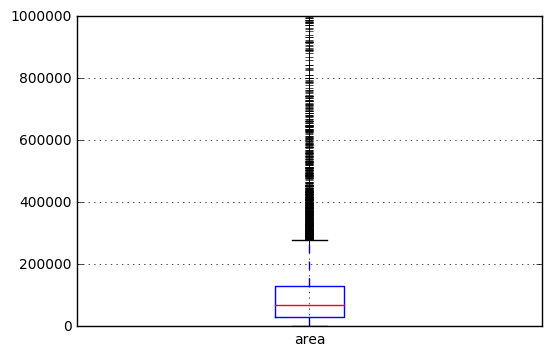

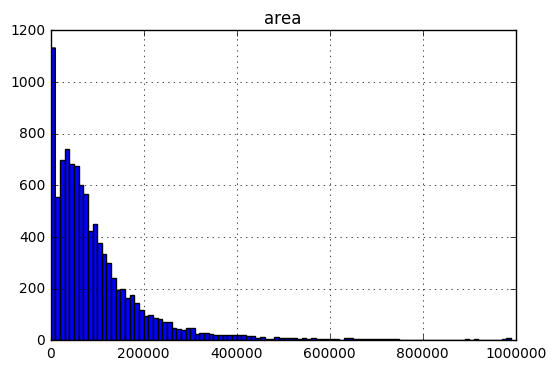

In [15]:
gdf.query('area>0 & area<1000000').boxplot('area')
gdf.query('area>0 & area<1000000').hist('area',bins=np.arange(0,1000000,10000))

In [16]:
gdf.query('area>0 & area<1000000').describe()

,area
count,10069.000000
mean,105199.105775
std,124261.351483
min,42.746447
25%,31640.667911
50%,68776.771683
75%,130443.126304
max,998461.733887


### Sobre os novos resultados
bom agora estamos considerando a maior parte da amostra, então estou tomando uma postura menos conservadora, porém isso me garante sobre possíveis erros nos meus conjuntos de dados. sobre o boxplot temos muitos valores acima de 300.000 m² que são considerados outliers. Temos uma curva bem assimétrica das áreas

### em resumo
tivemos uma noção geral das áreas, usando a mediana (50%) podemos dizer que os pontos abrangem por volta de 60.000m². parece pouco para um ponto de ônibus. Então isso traz mais uma pergunta:

# Número de pessoas!!!!!

então vou voltar a usar o shape de densidade populaciona. Primeiro, vamos terminar a análise calculando as maiores distâncias e depois vamos atacar a questão do número de pessoas para cada uma das regiões.

In [17]:
def MaiorDistanciaDoPontoDeOnibus(poly):
    
    pc = poly.centroid
    print(poly)
    exterior = asMultiPoint(poly.exterior)

    distance =  max([pc.distance(ex) for ex in exterior])

    return distance

gdf['MaiorDistancia']= gdf.geometry.apply(MaiorDistanciaDoPontoDeOnibus)

POLYGON ((362320.7268541709 7403164.704552136, 360064.0658255985 7401929.314735272, 359213.9078852256 7402030.973793144, 359258.3232291166 7402287.379150824, 362320.7268541709 7403164.704552136))
POLYGON ((360064.0658255985 7401929.314735272, 362320.7268541709 7403164.704552136, 363213.6448593574 7403580.226743855, 359632.5358001582 7401077.495476803, 359498.7648396433 7401431.750660394, 359866.9572993616 7401804.395068973, 360064.0658255985 7401929.314735272))
POLYGON ((362320.7268541709 7403164.704552136, 359258.3232291166 7402287.379150824, 358934.1909110845 7402285.986920412, 358922.9559183095 7402292.339342364, 358794.0754610435 7402467.93629246, 323719.1783508867 7401605.10122389, 390846.4886275108 7416581.456065461, 363213.6448593574 7403580.226743855, 362320.7268541709 7403164.704552136))
POLYGON ((359258.3232291166 7402287.379150824, 359213.9078852256 7402030.973793144, 359074.6945846105 7401913.230989069, 358934.1909110845 7402285.986920412, 359258.3232291166 7402287.37915082